Silhouette Score: 0.07379790821484125


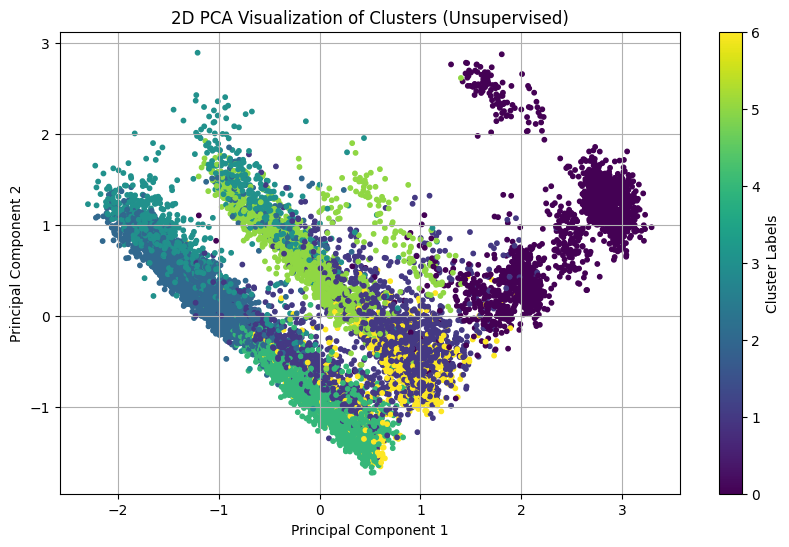

In [1]:
import pandas as pd
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../date/clean_data_filtered.csv'  # Update this path as needed
data = pd.read_csv(file_path)

# Preprocessing
# Drop irrelevant columns and the `Genre` column
data = data.drop(columns=['Wiki Page', 'Title', 'Director', 'Cast', 'Genre'])

# Encode categorical variables
label_encoder = LabelEncoder()
data['Origin/Ethnicity'] = label_encoder.fit_transform(data['Origin/Ethnicity'])

# TF-IDF for 'Plot' column
tfidf_vectorizer = TfidfVectorizer(max_features=100)
plot_tfidf = tfidf_vectorizer.fit_transform(data['Plot'].fillna(''))

# Word2Vec for 'Plot' column
tokenized_plots = data['Plot'].fillna('').apply(lambda x: x.split())
word2vec_model = Word2Vec(sentences=tokenized_plots, vector_size=80, window=5, min_count=1, workers=4)

def get_plot_embedding(plot):
    embeddings = [word2vec_model.wv[word] for word in plot if word in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

plot_word2vec = tokenized_plots.apply(get_plot_embedding)
plot_word2vec = np.vstack(plot_word2vec.values)

# Combine TF-IDF and Word2Vec features for 'Plot'
combined_text_features = np.hstack((plot_word2vec, plot_tfidf.toarray()))

# Combine numeric and textual features
numeric_features = data[['Release Year', 'Origin/Ethnicity']].values
numeric_features = StandardScaler().fit_transform(numeric_features)
combined_features = np.hstack((numeric_features, combined_text_features))

# Apply Birch Clustering on the combined features
birch_model = Birch(n_clusters=7, threshold=0.3, branching_factor=50)
birch_model.fit(combined_features)

# Get cluster labels
cluster_labels = birch_model.labels_

# Evaluate clustering performance
# Silhouette Score (unsupervised metric)
silhouette_avg = silhouette_score(combined_features, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Reduce features to 2D for visualization using PCA
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(combined_features)

# 2D scatter plot of clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_2d[:, 0], reduced_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.colorbar(scatter, label="Cluster Labels")
plt.title("2D PCA Visualization of Clusters (Unsupervised)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
